In [8]:
import torch
import torch.nn as nn
import torch.autograd as autograd

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
device_name = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
def analytic_solution(t, x_0=1.0, v_0=0.0):
    return x_0 * np.cos(t) + v_0 * np.sin(t)

### Architecture for Initial Conditions Fixed Nueral Network

In [21]:
class HarmonicModel(nn.Module):
    def __init__(self, x0, v0):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        self.x0 = x0
        self.v0 = v0

    def forward(self, t):
        a = self.network(t)
        return self.x0 + self.v0 * t + a * t**2

In [25]:
def train_model(model):
    num_samples = 200
    epochs = 2000
    lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    values = torch.linspace(0, 2 * np.pi, num_samples, device=device_name).view(-1, 1).requires_grad_()
    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        x_predicted = model(values)

        dx = autograd.grad(x_predicted, values, torch.ones_like(x_predicted), create_graph=True)[0]
        d2x = autograd.grad(dx, values, torch.ones_like(dx), create_graph=True)[0]

        loss = torch.mean((d2x + x_predicted) ** 2)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

        if epoch % 10 == 0:
            loss_history.append((epoch, loss.item()))

    return loss_history

In [26]:
x0 = 1.0
v0 = 1.0
model = HarmonicModel(x0, v0).to(device_name)

Epoch 0: Loss = 11.233688
Epoch 500: Loss = 0.045333
Epoch 1000: Loss = 0.016686
Epoch 1500: Loss = 0.017797


Text(0.5, 1.0, 'Training Loss over Epochs')

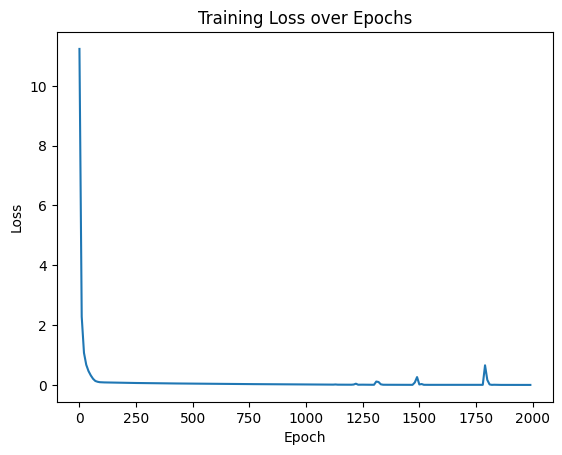

In [27]:
loss_history = train_model(model)
plt.plot(*zip(*loss_history), label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')

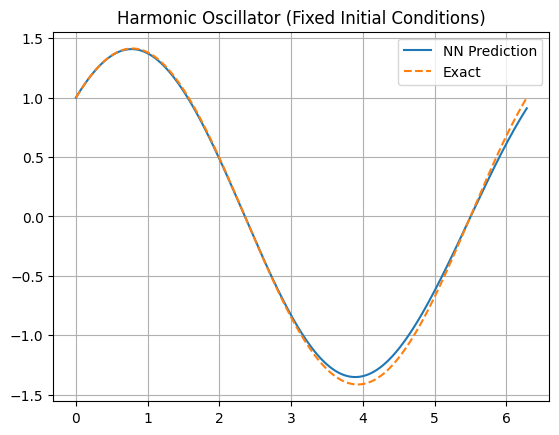

In [28]:
validation_values = torch.linspace(0, 2 * np.pi, 300, device=device_name).view(-1, 1)
with torch.no_grad():
    x_nn = model(validation_values).cpu().numpy()

x_true = analytic_solution(validation_values.cpu().numpy(), x_0=x0, v_0=v0)

plt.plot(validation_values.cpu(), x_nn, label='NN Prediction')
plt.plot(validation_values.cpu(), x_true, '--', label='Exact')
plt.title("Harmonic Oscillator (Fixed Initial Conditions)")
plt.legend()
plt.grid()
plt.show()


### Architecture for Boundary Conditions Fixed Neural Network